# COMP41680 API Assignment 1
## Robert Keenan 15333066
### An Aviation API and Weather API

## Step 1: APIs
For the first API, I have chosen to use the Aviationstack API which is one of the largest and most utilised APIs for real time and historical flight data. I will use this in unison with a weather API which will be used to determine the correlation/relationship between the weather and flight's statuses at different airports. I will then further investigate whether the weather affects different airlines, routes or airplane models differently such as between a small regional jet and a large, long range jet such as the Boeing 777.
- The Aviationstack API can be found here: https://aviationstack.com
- The weather API can be found here at: TODO/FIXME

I will firstly import any libraries or packages needed and then make a start on the data collection stage of the assignment. 

Each API has thorough documentation on their websites detailing all of the endpoints available to a user, how to make an API request and how to tailor these requests for the information you need for your purpose.

### API 1: Aviationstack API 
I received an API key for my Aviationstack account which is given as b4a871dbf85b4f670dafbdc9615a68e9.
In terms of the Aviationstack API, a number of pieces of information can be gathered such as real-time or historical data, different routes, airports, planes, aircraft types and countries. All of these endpoints or pieces of information can be used to infer something from the data.
The Aviationstack API allows 500 free API requests a month and I chose this one over FlightAware as FlightAware charges for each request.

With the aviationstack API, each API call returns 100 flights using the "flights" endpoint which is determined by the "limit" of 100. Unfortunately the limit is 100 for the free and basic paid plans. I have the Free plan which allows you the 500 API calls a month, but I emailed the Customer Support team who were happy to give me a free upgrade to the Basic Plan for 2 weeks to complete the project which allows 10,000 calls a month as well as access to Historical flight data which would make my analysis a little easier. If I wanted to gather 300 items from the same endpoint, I would need to use the "offset" variable to move the starting point by 100 each time. This would mean I had 3 files.

These 3 JSON files will need to be cleaned and combined with each other to create one file. 


### API 2: World Weather Online API

FIXME TALK ABOUT THE WEATHER API



In [1]:
import os
import urllib.request
import fnmatch
import csv
import json
import pandas as pd 
from pandas.io.json import json_normalize
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import math
import requests
from ipyleaflet import Map, Marker
from locationiq.geocoder import LocationIQ
import time
%matplotlib inline

In [2]:
params_departure_active = {
    'access_key': 'b4a871dbf85b4f670dafbdc9615a68e9',
    'dep_iata': 'LHR',
    'flight_status': 'active',
    'airline_iata': 'BA',
}

In this section, I will define the utility functions which will take the JSON data, parse into a file and then save these files in date specific formats.

In [3]:
def API_request_write_to_file(name_of_file, endpoint, params):
    if endpoint == 'flights':
        data = requests.get('http://api.aviationstack.com/v1/flights', params)
    elif endpoint == 'airports':
        data = requests.get('http://api.aviationstack.com/v1/airports', params)
    else:
        data = requests.get('http://api.worldweatheronline.com/premium/v1/past-weather.ashx', params)
    now = datetime.now()
    dt_string = now.strftime("%d-%m_%H_%M")
    data_json = data.json()
    THIS_FOLDER = os.path.abspath(os.getcwd())
    new_file_name = os.path.join(THIS_FOLDER, str(name_of_file)+'_'+ str(dt_string) +'.json')
    with open(new_file_name, 'w+', encoding='utf-8') as new_json_file:
        json.dump(data_json, new_json_file, ensure_ascii=False, indent=4)



In [4]:
API_request_write_to_file('NY_all_LA_JFK_100_6thMarch', 'flights', params_NY_LA)
#API_request_write_to_file('Dublin_arr_400_13thJan', 'flights', params_Dublin_Airport)

From here, I need to do the weather API and also be able to parse the data to see if I can see the relationships. In terms of data that is delayed and not delayed in terms of the files, I can check to see if the files are common and just take the delayed ones out that are currently in the file, if not add them

## Case 1: Dublin Airport's Routes
In this case, I decided to use the aviationstack API to find out the most popular routes and airlines into and out of Dublin Airport on the 5th of March 2020. In this case, the real time flights endpoint will provide with all of the flights in a day. I used the parameters of "flight_status": "landed", "dep_iata": "DUB" and obviously, I needed "offset" to iterate through the results as I am limited to 100 results per API call. DUB is the IATA code of Dublin Airport. I could have used the ICAO code of EIDW either. In this case, I have obtained over 800 flights for departures which will need to be combined together before I can use the for analysis. 

### Step 1: Loading and cleaning API data
In terms of the aviationstack API data which is now stored in JSON file format. I will need to load it, normalize it into an appropriate data structure so that I can analyse the data. Each flight or item in an API request has a number of fields such as "departure", "arrival", "airline", "aircraft" and many more. Inside each of these fields is a lot more information such as IATA/ICAO codes, airport information and aircraft registrations. 

However, the majority of this information is available to me in an API request but sometimes some of this information is returned as "null" such as the aircraft model type and its registration which is more than likely the most common. One of the fields, "live", is relegated for information about a live flight still in the air but I have preferred to use flights that have a status of "landed". As a result, it is up to me to load the data and clean it appropriately so that I can interpret the data properly without the effect of these redundant variables.

In other case that I need to consider is that codeshares between airlines can make the data awkward to deal with. In the case of a flight from Dublin to London Heathrow, the airline reported by the API request could be Qatar Airways which is a member of OneWorld Alliance with British Airways who actually operated the flight. As a result, I need to delete these codeshared flights if the original flight is also present in the API request. 

In [5]:
def combine_data_frames(start_filename, save_filename):
    #This will count the number of files which use this preamble
    num_files = 0
    #Initialise list to store names
    file_matches = []
    for name in os.listdir('.'):
        if start_filename in name:
              file_matches.append(name)
            
    for index,file in enumerate(file_matches):
        with open(file, 'r') as file_to_join:
            data = json.load(file_to_join)
        #Normalizing the data
        normalized_data = json_normalize(data['data'])
        #If first iteration, create the data frame 
        if index == 0:
            data_frame = pd.DataFrame(normalized_data)
        else:
            data_frame_add = pd.DataFrame(normalized_data)
            data_frame = pd.concat([data_frame, data_frame_add], ignore_index=True, sort = True)
    #return data_frame
    data_frame.to_json(save_filename, orient='records')
    
    
# This codeshare function will check if the flight number is common in multiple places.
# If it is present in the codeshare section and the codeshare of the original flight number is present, 
# delete the other flight
def codeshare_flight_deletion(data_frame):
    #Takes in the data frame and looks at each of the flight_numbers and the
    flight_times = data_frame['departure.scheduled']
    flight_numbers = data_frame['flight.iata']
    codeshared_flight = data_frame['flight.codeshared.flight_iata']
    for index,num in enumerate(codeshared_flight):
        #Need to continually update the flight numbers
        #flight_numbers = data_frame['flight.iata']
        if num != 'nan' or num != None or num != 'NaN':
            for index_2, flight_num in enumerate(flight_numbers):
                #This checks that the flight number is the same and that the departure times are the same
                #FIXME 
                if flight_num == None:
                    continue
                if num == flight_num.lower() and flight_times[index] == flight_times[index_2]:
                    data_frame.drop(index, axis = 0, inplace = True)
                    print("Codeshare Flight "+num+" has been deleted")
                    break
                else:
                    continue
        #There is a NaN for the codeshare so go through
        else:
            continue
    data_frame.reset_index(drop = True, inplace = True)
    return data_frame
  
def day_time_data(day_flight_data):
    date = day_flight_data['flight_date']
    midnight_6am = [date+'T00:01:00+00:00', date+'T06:00:00+00:00']
    six_12pm = [date+'T06:01:00+00:00', date+'T12:00:00+00:00']
    midday_6pm = [date+'T12:01:00+00:00', date+'T18:00:00+00:00']
    six_12am = [date+'T18:01:00+00:00', date+'T23:59:00+00:00']
    
    flights_1 = day_flight_data['departure.scheduled'].between(midnight_6am[0], midnight_6am[1], inclusive=True).value_counts()
    flights_2 = day_flight_data['departure.scheduled'].between(six_12pm[0], six_12pm[1], inclusive=True).value_counts()
    flights_3 = day_flight_data['departure.scheduled'].between(midday_6pm[0], midday_6pm[1], inclusive=True).value_counts()
    flights_4 = day_flight_data['departure.scheduled'].between(six_12am[0], six_12am[1], inclusive=True).value_counts()
    if True in flights_1:
        time_1 = flights_1[1]
    else:
        time_1 = 0
    if True in flights_2:
        time_2 = flights_2[1]
    else:
        time_2 = 0
    if True in flights_3:
        time_3 = flights_3[1]
    else:
        time_3 = 0
    if True in flights_4:
        time_4 = flights_4[1]
    else:
        time_4 = 0
    return time_1, time_2, time_3, time_4

In [6]:
DUB_data_1 = combine_data_frames('Dublin_biggest_departures_', 'Dublin_departures_landed.json')
with open('Dublin_departures_landed.json', 'r') as file_to_join:
    data = json.load(file_to_join)
    #Normalizing the data
    normalized_data = json_normalize(data)
    DUB_data_1 = pd.DataFrame(normalized_data)
DUB_data_1

,aircraft,aircraft.iata,aircraft.icao,aircraft.icao24,aircraft.registration,airline.iata,airline.icao,airline.name,arrival.actual,arrival.actual_runway,...,flight.codeshared.airline_name,flight.codeshared.flight_iata,flight.codeshared.flight_icao,flight.codeshared.flight_number,flight.iata,flight.icao,flight.number,flight_date,flight_status,live
0,None,None,None,None,None,RE,STK,Stobart Air,None,2020-03-05T09:27:00+00:00,...,None,None,None,None,RE3390,STK3390,3390,2020-03-05,landed,None
1,None,None,None,None,None,RE,STK,Stobart Air,None,2020-03-05T18:15:00+00:00,...,None,None,None,None,RE3394,STK3394,3394,2020-03-05,landed,None
2,None,None,None,None,None,FR,RYR,Ryanair,2020-03-05T12:39:00+00:00,2020-03-05T12:37:00+00:00,...,None,None,None,None,FR1978,RYR1978,1978,2020-03-05,landed,None
3,None,None,None,None,None,BA,BAW,British Airways,2020-03-05T08:29:00+00:00,2020-03-05T08:22:00+00:00,...,ba cityflyer,cj4461,cfe4461,4461,BA4461,BAW4461,4461,2020-03-05,landed,None
4,None,None,None,None,None,BA,BAW,British Airways,2020-03-05T10:01:00+00:00,2020-03-05T09:57:00+00:00,...,ba cityflyer,cj4463,cfe4463,4463,BA4463,BAW4463,4463,2020-03-05,landed,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,None,None,None,None,None,EY,ETD,Etihad Airways,None,2020-03-05T13:04:00+00:00,...,aer lingus,ei137,ein137,137,EY7977,ETD7977,7977,2020-03-05,landed,None
530,None,None,None,None,None,UA,UAL,United Airlines,None,2020-03-05T13:04:00+00:00,...,aer lingus,ei137,ein137,137,UA7637,UAL7637,7637,2020-03-05,landed,None
531,None,None,None,None,None,BA,BAW,British Airways,None,2020-03-05T07:52:00+00:00,...,stobart air,re3280,stk3280,3280,BA8880,BAW8880,8880,2020-03-05,landed,None
532,None,None,None,None,None,BA,BAW,British Airways,None,2020-03-05T11:00:00+00:00,...,stobart air,re3282,stk3282,3282,BA8882,BAW8882,8882,2020-03-05,landed,None


From here, I can normalize the JSON data to create a flat table and then use Pandas to convert to a 2D data structure. 

In [7]:
#I access the 'data' field as the other information is the pagination offsets and limits which are not needed

# There are a number of columns in the Data Frame and I need to see what these are and they are
# related to the pagination information about offsets. I need to remove these and then access the info inside
print(DUB_data_1.columns)



Index(['aircraft', 'aircraft.iata', 'aircraft.icao', 'aircraft.icao24',
       'aircraft.registration', 'airline.iata', 'airline.icao', 'airline.name',
       'arrival.actual', 'arrival.actual_runway', 'arrival.airport',
       'arrival.baggage', 'arrival.delay', 'arrival.estimated',
       'arrival.estimated_runway', 'arrival.gate', 'arrival.iata',
       'arrival.icao', 'arrival.scheduled', 'arrival.terminal',
       'arrival.timezone', 'departure.actual', 'departure.actual_runway',
       'departure.airport', 'departure.delay', 'departure.estimated',
       'departure.estimated_runway', 'departure.gate', 'departure.iata',
       'departure.icao', 'departure.scheduled', 'departure.terminal',
       'departure.timezone', 'flight.codeshared',
       'flight.codeshared.airline_iata', 'flight.codeshared.airline_icao',
       'flight.codeshared.airline_name', 'flight.codeshared.flight_iata',
       'flight.codeshared.flight_icao', 'flight.codeshared.flight_number',
       'flight.iata', '

I need to take account for the codeshared flights which are not valid in this case. After this, I can delete the data columns which are not needed. 

In [8]:
print("Number of flights in data structure: "+ str(DUB_data_1.shape[0]))

Number of flights in data structure: 534


In [9]:
#Running the Codeshare clean function which gets rid of the codeshared flights that have a flight already in the data
clean_DUB_data_1 = codeshare_flight_deletion(DUB_data_1)
clean_DUB_data_1.reset_index(drop=True, inplace=True)

Codeshare Flight cj4461 has been deleted
Codeshare Flight cj4463 has been deleted
Codeshare Flight cj4465 has been deleted
Codeshare Flight cj4467 has been deleted
Codeshare Flight cj4469 has been deleted
Codeshare Flight cj4471 has been deleted
Codeshare Flight cj4473 has been deleted
Codeshare Flight wx280 has been deleted
Codeshare Flight wx282 has been deleted
Codeshare Flight wx284 has been deleted
Codeshare Flight wx286 has been deleted
Codeshare Flight wx288 has been deleted
Codeshare Flight cj4461 has been deleted
Codeshare Flight cj4463 has been deleted
Codeshare Flight cj4465 has been deleted
Codeshare Flight cj4467 has been deleted
Codeshare Flight cj4469 has been deleted
Codeshare Flight cj4471 has been deleted
Codeshare Flight cj4473 has been deleted
Codeshare Flight ei230 has been deleted
Codeshare Flight ei232 has been deleted
Codeshare Flight ei236 has been deleted
Codeshare Flight ei238 has been deleted
Codeshare Flight ei246 has been deleted
Codeshare Flight ei248 has

In [10]:
#Printing to show that codeshared flights have been removed that have a flight number elsewhere
print("Number of flights after cleaning codeshared flights: "+str(clean_DUB_data_1.shape[0]))

Number of flights after cleaning codeshared flights: 249


This shows that there are a lot of codeshare flights returned in a single API request with a total of 900 flights gathered but only 427 singular routes/flights. As a result, I have shown the effect that cleaning data has had as I could have concluded something incorrect about the data due to the sheer number of codeshare flights. 





In the case of the data currently, there is a lot of columns that I do not need. These include scheduled flight times, runways, terminal numbers, gate numbers, aircraft types and many more. These will be needed later but for the case of this initial test they will not. Hence, I will now get rid of these columns which were printed out before hand. 
I want to simplify the data frame for the following features:
- Departure Time
- Arrival Airport 
- Arrival IATA airport code
- Airline Name
- Airline IATA code


In [11]:
#Clean the data for the specific date
clean_DUB_data_1 = clean_DUB_data_1[clean_DUB_data_1['flight_date'] == '2020-03-05']
simplified_data = clean_DUB_data_1[['departure.scheduled', 'arrival.airport', 'arrival.iata', 'airline.name', 'airline.iata']]
print("Number of flights: "+str(clean_DUB_data_1.shape[0]))

Number of flights: 249


I am now checking that the data returned to me is all present and doesn't have any NULL values

In [12]:
simplified_data.isnull().sum()

departure.scheduled    0
arrival.airport        0
arrival.iata           0
airline.name           0
airline.iata           0
dtype: int64

Now checking that the simplified data has been returned properly by plotting the first 10 flights

In [13]:
simplified_data[0:10]

,departure.scheduled,arrival.airport,arrival.iata,airline.name,airline.iata
0,2020-03-05T06:50:00+00:00,Leeds/bradford,LBA,Stobart Air,RE
1,2020-03-05T17:25:00+00:00,Leeds/bradford,LBA,Stobart Air,RE
2,2020-03-05T09:35:00+00:00,Lodz Lublinek,LCJ,Ryanair,FR
3,2020-03-05T07:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
4,2020-03-05T08:50:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
5,2020-03-05T11:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
6,2020-03-05T16:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
7,2020-03-05T17:05:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
8,2020-03-05T20:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
9,2020-03-05T19:15:00+00:00,London City Airport,LCY,BA Cityflyer,CJ


As we can see from the readout above, the data headings/column headings are laid out in an inituitive way but it is not very presentable in that fashion. As a result, I can rename the columns as appropriate.

I am using a mappping to the headings as the pd.DataFrame.rename() function sometimes has trouble interpreting what you mean when you want to rename something

In [14]:
 map_headings = {simplified_data.columns[0]: 'Scheduled Departure Time', 
                 simplified_data.columns[1]: 'Destination Airport', 
                 simplified_data.columns[2]: 'Destination IATA Code', 
                 simplified_data.columns[3]: 'Airline Name',
                 simplified_data.columns[4]: 'Airline IATA Code'}
                 
simplified_data = simplified_data.rename(columns=map_headings)
simplified_data[0:10]



,Scheduled Departure Time,Destination Airport,Destination IATA Code,Airline Name,Airline IATA Code
0,2020-03-05T06:50:00+00:00,Leeds/bradford,LBA,Stobart Air,RE
1,2020-03-05T17:25:00+00:00,Leeds/bradford,LBA,Stobart Air,RE
2,2020-03-05T09:35:00+00:00,Lodz Lublinek,LCJ,Ryanair,FR
3,2020-03-05T07:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
4,2020-03-05T08:50:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
5,2020-03-05T11:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
6,2020-03-05T16:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
7,2020-03-05T17:05:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
8,2020-03-05T20:00:00+00:00,London City Airport,LCY,BA Cityflyer,CJ
9,2020-03-05T19:15:00+00:00,London City Airport,LCY,BA Cityflyer,CJ


After the data has been cleaned appropriately as it has been above for just the destination airport and the airline to that destination airport. I can present the most popular destination airports for flights out of Dublin Airport on the 5th of March 2020 and airlines for those routes.
I will firstly characterise the Top 10 most popular airports for clarity

Text(0, 0.5, 'Number of Flights')

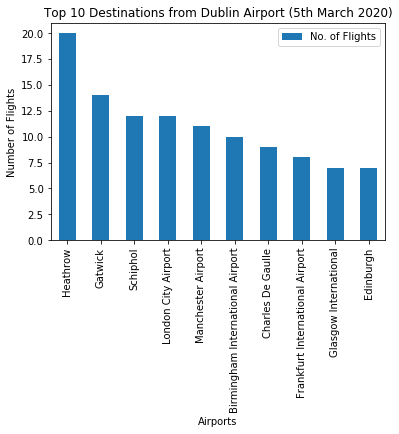

In [15]:
top_10_airport_numbers = simplified_data["Destination Airport"].value_counts()[0:10]
#Need to turn into a data frame to plot 
most_popular_airports = pd.DataFrame(top_10_airport_numbers)
most_popular_airports = most_popular_airports.rename(columns={'Destination Airport': 'No. of Flights'})
most_popular_airports_plot = most_popular_airports.plot(kind = 'bar', 
                                                        title="Top 10 Destinations from Dublin Airport (5th March 2020)")
most_popular_airports_plot.set_xlabel("Airports")
most_popular_airports_plot.set_ylabel("Number of Flights")

In [16]:
top_10_airport_numbers

Heathrow                            20
Gatwick                             14
Schiphol                            12
London City Airport                 12
Manchester Airport                  11
Birmingham International Airport    10
Charles De Gaulle                    9
Frankfurt International Airport      8
Glasgow International                7
Edinburgh                            7
Name: Destination Airport, dtype: int64

Getting the most common airports, I will need to store the most popular airports before then using the search parameter from the API documentation to find the airport before getting their longitude and latitude and plotting them.
I can use the IATA codes which will be unique for each airport and make sure that there are no changes


In [17]:
IATA_codes_most_popular = simplified_data["Destination Airport"].value_counts()[0:5]
list_of_airports = IATA_codes_most_popular.index.tolist()
list_of_airports

['Heathrow',
 'Gatwick',
 'Schiphol',
 'London City Airport',
 'Manchester Airport']

In [24]:
airport_locs = pd.DataFrame({'Name' : [], 'Latitude': [], 'Longitude': []})
#Add airport to the string
list_of_airports = [airport+ ' Airport' if 'Airport' not in airport else airport for airport in list_of_airports]
geocoder = LocationIQ('5798d7a2381f01')
for index,name in enumerate(list_of_airports):
    location = geocoder.geocode(name)
    longitude = float(location[0]['lon'])
    latitude = float(location[0]['lat'])
    title = location[0]['display_name']
    airport_locs = airport_locs.append({'Name': title, 'Latitude': latitude, 'Longitude': longitude}, ignore_index=True)
    time.sleep(0.5)
airport_locs.to_json('top_5_airports.json', orient='records')

with open('top_5_airports.json', 'r') as airports:
    data = json.load(airports)
    #Normalizing the data
    normalized_data = json_normalize(data)
    airport_locs = pd.DataFrame(normalized_data)


midpoint_lat = ((airport_locs.iloc[0]['Latitude']+airport_locs.iloc[1]['Latitude']+airport_locs.iloc[2]['Latitude']+\
               airport_locs.iloc[3]['Latitude']+airport_locs.iloc[4]['Latitude'])/5)
midpoint_lon = ((airport_locs.iloc[0]['Longitude']+airport_locs.iloc[1]['Longitude']+airport_locs.iloc[2]['Longitude']+\
               airport_locs.iloc[3]['Longitude']+airport_locs.iloc[4]['Longitude'])/5)
center = (midpoint_lat, midpoint_lon)

map_airports = Map(center=center, zoom=6)
marker1 = Marker(location=(airport_locs.iloc[0]['Latitude'], airport_locs.iloc[0]['Longitude']),\
                 draggable=False, title=airport_locs.iloc[0]['Name'])
marker2 = Marker(location=(airport_locs.iloc[1]['Latitude'], airport_locs.iloc[1]['Longitude']),\
                 draggable=False, title=airport_locs.iloc[1]['Name'])
marker3 = Marker(location=(airport_locs.iloc[2]['Latitude'], airport_locs.iloc[2]['Longitude']),\
                 draggable=False, title=airport_locs.iloc[2]['Name'])
marker4 = Marker(location=(airport_locs.iloc[3]['Latitude'], airport_locs.iloc[3]['Longitude']),\
                 draggable=False, title=airport_locs.iloc[3]['Name'])
marker5 = Marker(location=(airport_locs.iloc[4]['Latitude'], airport_locs.iloc[4]['Longitude']),\
                 draggable=False, title=airport_locs.iloc[4]['Name'])
map_airports.add_layer(marker1);
map_airports.add_layer(marker2);
map_airports.add_layer(marker3);
map_airports.add_layer(marker4);
map_airports.add_layer(marker5);

map_airports

Map(center=[51.95772495, 0.38183760592000004], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

I needed to do this as the API request for flights only gives you the the airport name and codes rather than their location

In [19]:
airport_locs

,Name,Latitude,Longitude
0,"London Heathrow Airport, St. Anthony's Way, Ra...",51.467771,-0.459082
1,"Gatwick Airport, Station Approach Road, Crawle...",51.156724,-0.161019
2,"Schiphol Airport, Jan Dellaertplein, Schiphol,...",52.309523,4.762181
3,"London City Airport, Parker Street, Silvertown...",51.504266,0.047477
4,"Manchester Airport, Rivermead Avenue, Timperle...",53.350342,-2.280369


### Most Common Airports and the Airlines that serve them
From here on I need to look at the most common locations, the most common airlines and the most


In [ ]:
most_popular_airlines_airport = simplified_data.groupby('Destination Airport')
Total_Airports = most_popular_airlines_airport.sum()
Total_Airports = Total_Airports.sort_values('Airline Name', ascending = False)
#most_pop_airlines_for_airport = Total_Airports.plot(kind='bar')
#for key, item in most_popular_airlines_airport:
 #   print(most_popular_airlines_airport.get_group(key), "\n\n")
airport = list_of_airports[2]
airlines_at_airport = most_popular_airlines_airport.get_group(airport)
plot = airlines_at_airport['Airline Name'].value_counts().plot(kind='bar', 
                                                        title='Biggest Airlines to Amsterdam Schiphol', rot=0)
plot.set_xlabel("Airlines")
plot.set_ylabel("Number of Flights")

FIXME talk about how running the API at certain times has an effect and how some of the flights still say scheduled mainly because they are american flights and by the time they land and then the API updates with information, the flight will not be updated or landed yet

In the section below, I will look at the busiest terminals in a day followed by the most common times that these terminals are accessed

In [ ]:
terminal_data = clean_DUB_data_1[['departure.scheduled','flight_date', 'departure.terminal', 'arrival.airport',\
                                  'arrival.iata', 'airline.name', 'airline.iata']]

In [ ]:
#This just checks that none of the data is missing for terminal etc
terminal_data.isnull().sum()

In [ ]:
terminals = terminal_data['departure.terminal'].value_counts()
#On the 5th of March 2020
print("Number of Terminal 1 Departures: %d flights\nNumber of Terminal 2 Departures: %d flights" 
      % (terminals.iloc[0], terminals.iloc[1]))

From here, I need to see what airlines depart from which terminals and then see the busier times such as how many flights leave between each time from each terminal. I could group them between each time like a column for 0-6am, 6-12pm, 12-6pm  and then 6-12am. 

In [ ]:
#Needs to be given in format of the following
#FIXME this will need to be changed for flight_date

midnight, six_am, midday, six_pm = day_time_data(terminal_data)

flights_times = pd.DataFrame({'Flights': [midnight, six_am,midday, six_pm]}, \
                             index = ['12am-6am', '6am-12pm', '12pm-6pm', '6pm-12am'])

plot = flights_times.plot(kind='bar', title='Distribution of Departures throughout the day', rot=0)
plot.set_xlabel("Departure Time Ranges")
plot.set_ylabel("Number of Flights")


In [ ]:
#Verifying the total number of flights is the same
flights_times.sum()

In [ ]:
flights_times

FIXME Next Step to do is to see what airlines take off between each time, so we will do the top 5 airlines as the x ticks and then have the 4 different plots for the different times that they take off at

In [ ]:
#Get the most common airlines first
top_airlines = terminal_data["airline.name"].value_counts()[0:2]
top_airlines  = top_airlines.index.tolist()
top_airlines
#Now that I have the top airlines, I can see when they are using each time

In [ ]:
#terminal_data[flights_1[flights_1 == (True)]]
#I now need to get the airlines for thi
########
################################################################################################
################################################################################################
################################################################################################
# FIXXXXMMMEEEEEE MAKE THIS WAY SHORTER AS IT IS OBNOXIOUS TO LOOK AT. FIX WHEN I AM DONE
################################################################################################
################################################################################################
midnight_6am = ['2020-03-05T00:01:00+00:00', '2020-03-05T06:00:00+00:00']
six_12pm = ['2020-03-05T06:01:00+00:00', '2020-03-05T12:00:00+00:00']
midday_6pm = ['2020-03-05T12:01:00+00:00', '2020-03-05T18:00:00+00:00']
six_12am = ['2020-03-05T18:01:00+00:00', '2020-03-05T23:59:00+00:00']

flights_1 = terminal_data['departure.scheduled'].between(midnight_6am[0], midnight_6am[1], inclusive=True)
flights_2 = terminal_data['departure.scheduled'].between(six_12pm[0], six_12pm[1], inclusive=True)
flights_3 = terminal_data['departure.scheduled'].between(midday_6pm[0], midday_6pm[1], inclusive=True)
flights_4 = terminal_data['departure.scheduled'].between(six_12am[0], six_12am[1], inclusive=True)

#These are the indexes of the flights that leave inside of these times
midnight_flights = (flights_1[flights_1 == (True)]).index.tolist()
six_am_flights = (flights_2[flights_2 == (True)]).index.tolist()
midday_flights = (flights_3[flights_3 == (True)]).index.tolist()
six_pm_flights = (flights_4[flights_4 == (True)]).index.tolist()

#FIXME , look for a better way to do this
airline_1_12am = terminal_data.iloc[midnight_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[0])
airline_2_12am = terminal_data.iloc[midnight_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[1])
airline_1_6am = terminal_data.iloc[six_am_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[0])
airline_2_6am = terminal_data.iloc[six_am_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[1])
airline_1_12pm = terminal_data.iloc[midday_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[0])
airline_2_12pm = terminal_data.iloc[midday_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[1])
airline_1_6pm = terminal_data.iloc[six_pm_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[0])
airline_2_6pm = terminal_data.iloc[six_pm_flights]['airline.name'].iloc[0:].tolist().count(top_airlines[1])

airline_times = pd.DataFrame({'12am-6am': [airline_1_12am, airline_2_12am], '6am-12pm': [airline_1_6am, airline_2_6am],
                             '12pm-6pm': [airline_1_12pm, airline_2_12pm], '6pm-12am': [airline_1_6pm, airline_2_6pm]}, 
                             index = ['Ryanair', 'Aer Lingus'])
plot = airline_times.plot(kind='bar', title = 'Distribution of Departures throughout a day (Ryanair/Aer Lingus)', rot=0)
plot.set_xlabel("Top 2 Airlines")
plot.set_ylabel("Number of Flights")

In [ ]:
airline_times.describe()
#FIXME

In [ ]:
airline_times

In [ ]:
terminal_1_12am = terminal_data.iloc[midnight_flights]['departure.terminal'].iloc[0:].tolist().count('1')
terminal_2_12am = terminal_data.iloc[midnight_flights]['departure.terminal'].iloc[0:].tolist().count('2')
terminal_1_6am = terminal_data.iloc[six_am_flights]['departure.terminal'].iloc[0:].tolist().count('1')
terminal_2_6am = terminal_data.iloc[six_am_flights]['departure.terminal'].iloc[0:].tolist().count('2')
terminal_1_12pm = terminal_data.iloc[midday_flights]['departure.terminal'].iloc[0:].tolist().count('1')
terminal_2_12pm = terminal_data.iloc[midday_flights]['departure.terminal'].iloc[0:].tolist().count('2')
terminal_1_6pm = terminal_data.iloc[six_pm_flights]['departure.terminal'].iloc[0:].tolist().count('1')
terminal_2_6pm = terminal_data.iloc[six_pm_flights]['departure.terminal'].iloc[0:].tolist().count('2')


terminal_times = pd.DataFrame({'12am-6am': [terminal_1_12am, terminal_2_12am], '6am-12pm': [terminal_1_6am, terminal_2_6am],
                             '12pm-6pm': [terminal_1_12pm, terminal_2_12pm], '6pm-12am': [terminal_1_6pm, terminal_2_6pm]}, 
                              index = ['Terminal 1', 'Terminal 2'])
plot = terminal_times.plot(kind='bar', title = 'Distribution of Departures between Terminals (DUB/EIDW)', rot=0)
plot.set_xlabel("Terminals")
plot.set_ylabel("Number of Flights")

FIXME, FIND THE CORERLATION OR PLOT THE CORRELATION BETWEEN THE TERMINAL 1 and TERMINAL 2 data


Well now that I have found which are the busiest terminals,
Now i can do the legacy carriers in the US

### Legacy carriers in the USA
A common argument seen in the media is which is the most reliable airline of the 3 main US legacy carriers: United Airlines (UA), American Airlines (AA) and Delta Airlines (DL). One of the most competitive routes in the US for these 3 airlines is the perennial New York to Los Angeles route on which the airport slots are most expensive and cater mainly to business travelers between the 2 largest cities in the US who need reliability, consistency and a high frequency of flights per day. 

As a result, I will gather data for one week between New York and LA for the 3 legacy carriers as well as the young competitor, JetBlue. 
This involved taking data for flights that had a flight status of 'landed' according to the API between New York JFK(for American, Delta & JetBlue) and Newark Liberty Intl. (for United) to LAX. 

I will be able to study the frequency of the flights, the times at which these flights are served and how reliable they are in terms of on-time departures out of New York, especially the morning flights for business travelers.
I collected all of the departure data for these airlines between the 2nd and 6th of March 2020 inclusive.


In [ ]:
us_legacy_carriers = combine_data_frames('NY_to_LA_', 'US_legacy_carriers_NYLA.json')
with open('US_legacy_carriers_NYLA.json') as us_legacy_file:
    data = json.load(us_legacy_file)
    #Normalizing the data
    normalized_data = json_normalize(data)
    us_legacy_carriers = pd.DataFrame(normalized_data)

I then need to check for codeshares and get rid of them


In [ ]:
print('Current Number of Flights between New York and LA: %d' % (us_legacy_carriers.shape[0]))

In [ ]:
us_legacy_carriers = codeshare_flight_deletion(us_legacy_carriers)
us_legacy_carriers.reset_index(drop=True, inplace=True)

In [ ]:
print('Number of Flights after codeshares removed: %d' % (us_legacy_carriers.shape[0]))

I will first check whether any of the airline names are null before checking to see what airlines are listed as flying between the airports and I will remove the ones I do not need

In [ ]:
us_legacy_carriers['airline.name'].isnull().sum()

In [ ]:
us_legacy_carriers['airline.name'].value_counts()

From here, I can see that American Airlines is the largest carrier between the 3 legacy carriers by more than 6 flights per week than Delta and 9 flights more than United. JetBlue, being the younger competitor, has only one flight less per week on this important and expensive route and hence, I will need to include it in my analysis as it is very significant. 

In [ ]:
chosen_airlines = us_legacy_carriers[['departure.scheduled','flight_date', 'airline.name', 'departure.airport', 'departure.delay', 'arrival.delay']]

As I can see below, I have access to all of the flight's in one business week, their dates, times, departure airport and their delays.

In [ ]:
chosen_airlines

In [ ]:
#Can sort the values in chronological order
#Ignore index doesnt work for some reason

chosen_airlines = chosen_airlines.sort_values(by='departure.scheduled', ascending=True)
chosen_airlines.reset_index(drop=True,inplace=True)
chosen_airlines


Now that I have the flights for the week, I can filter out Alaska Airlines

In [ ]:
us_airlines_remove = chosen_airlines[(chosen_airlines['airline.name'] == 'Qantas') | \
                                     (chosen_airlines['airline.name'] == 'FedEx') | \
                                     (chosen_airlines['airline.name'] == 'Alaska Airlines')].index
# Delete these row indexes from dataFrame
chosen_airlines.drop(us_airlines_remove , inplace=True)
chosen_airlines.reset_index(drop=True, inplace=True)
chosen_airlines

From here, I can examine the distribution of flights throughout the week at different times. I will use the x axis as the days and the y axis as the number of flights

In [ ]:
#FIXME implement in a function
monday    = chosen_airlines[chosen_airlines['flight_date'] == '2020-03-02']
tuesday   = chosen_airlines[chosen_airlines['flight_date'] == '2020-03-03']
wednesday = chosen_airlines[chosen_airlines['flight_date'] == '2020-03-04']
thursday  = chosen_airlines[chosen_airlines['flight_date'] == '2020-03-05']
friday    = chosen_airlines[chosen_airlines['flight_date'] == '2020-03-06']

mon_12am, mon_6am, mon_12pm, mon_6pm = day_time_data(monday)
tue_12am, tues_6am, tues_12pm, tues_6pm = day_time_data(tuesday)
wed_12am, wed_6am, wed_12pm, wed_6pm = day_time_data(wednesday)
thur_12am, thur_6am, thur_12pm, thur_6pm = day_time_data(thursday)
fri_12am, fri_6am, fri_12pm, fri_6pm = day_time_data(friday)


#What i want to do is print each day to a data frame like below but for each day, there is
midnight_df = [mon_12am, tue_12am, wed_12am, thur_12am, fri_12am]
six_am_df = [mon_6am, tues_6am, wed_6am, thur_6am, fri_6am]
midday_df = [mon_12pm, tues_12pm, wed_12pm, thur_12pm, fri_12pm]
six_pm_df = [mon_6pm, tues_6pm, wed_6pm, thur_6pm, fri_6pm]

NY_to_LA_times = pd.DataFrame({'12am-6am': midnight_df, '6am-12pm': six_am_df, \
                               '12pm-6pm': midday_df, '6pm-12am': six_pm_df}, \
                              index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

NY_plot = NY_to_LA_times.plot(kind='bar', title = 'Departure Times for week ending 6th MAR 2020 for NY to LA',\
                           rot=0)
NY_plot.set_xlabel("Days of the Week")
NY_plot.set_ylabel("Number of Flights")




As we can see above, the flight data for a lot of the afternoon flights is missing. This could be due to the API not refreshing in time and as a result, it loses the data or perhaps the API no longer has access to the aircraft's inflight location for safety and security reasons which is the case in the USA. A lot of these API's and websites like FlightRadar24 use ADS-B receivers where the aircraft periodically broadcasts its location via satellite. These transponders are sometimes turned off on long journeys. 
Hence, I will now repeat the analysis above but for all flights regardless of their 'flight_status' such as 'active' or 'scheduled'. I will need to filter out cancelled flights. 

As a result below, I will gather the data for any possible flight status which will be saved to a file

In [ ]:
all_legacy_carrier_flights = combine_data_frames('NY_all_LA_', 'NY_LA_all_flight_statuses.json')
with open('NY_LA_all_flight_statuses.json') as us_legacy_new_file:
    data = json.load(us_legacy_new_file)
    #Normalizing the data
    normalized_data = json_normalize(data)
    all_legacy_carrier_flights = pd.DataFrame(normalized_data)


In [ ]:
print('Total Number of Flights gathered: %d' %(all_legacy_carrier_flights.shape[0]))

In [ ]:
#From here, I will now need to clean the codeshares
all_legacy_carrier_flights = codeshare_flight_deletion(all_legacy_carrier_flights)
all_legacy_carrier_flights.reset_index(drop=True, inplace=True)

In [ ]:
#From here I can print the final number of flights
print('Number of Flights after cleaning: %d' %(all_legacy_carrier_flights.shape[0]))

In [ ]:
all_legacy_carrier_flights['airline.name'].value_counts()

In [ ]:
airlines = all_legacy_carrier_flights[['departure.scheduled','flight_date', 'airline.name',\
                                       'departure.airport', 'departure.delay', 'arrival.delay', 'flight_status']]
airlines

In [ ]:
#Sorting the flights
airlines = airlines.sort_values(by='departure.scheduled', ascending=True)
airlines.reset_index(drop=True,inplace=True)
airlines

In [ ]:
# Removing Qantas, FedEx and Alaska
us_airlines_remove = airlines[(airlines['airline.name'] == 'Qantas') | \
                                     (airlines['airline.name'] == 'FedEx') | \
                                     (airlines['airline.name'] == 'Alaska Airlines')].index
airlines.drop(us_airlines_remove , inplace=True)
airlines.reset_index(drop=True, inplace=True)
airlines

In [ ]:
#Show that the airlines are gone
airlines['airline.name'].value_counts()

In [ ]:
monday    = airlines[airlines['flight_date'] == '2020-03-02']
tuesday   = airlines[airlines['flight_date'] == '2020-03-03']
wednesday = airlines[airlines['flight_date'] == '2020-03-04']
thursday  = airlines[airlines['flight_date'] == '2020-03-05']
friday    = airlines[airlines['flight_date'] == '2020-03-06']

mon_12am, mon_6am, mon_12pm, mon_6pm = day_time_data(monday)
tue_12am, tues_6am, tues_12pm, tues_6pm = day_time_data(tuesday)
wed_12am, wed_6am, wed_12pm, wed_6pm = day_time_data(wednesday)
thur_12am, thur_6am, thur_12pm, thur_6pm = day_time_data(thursday)
fri_12am, fri_6am, fri_12pm, fri_6pm = day_time_data(friday)


#What i want to do is print each day to a data frame like below but for each day, there is
midnight_df = [mon_12am, tue_12am, wed_12am, thur_12am, fri_12am]
six_am_df = [mon_6am, tues_6am, wed_6am, thur_6am, fri_6am]
midday_df = [mon_12pm, tues_12pm, wed_12pm, thur_12pm, fri_12pm]
six_pm_df = [mon_6pm, tues_6pm, wed_6pm, thur_6pm, fri_6pm]

NY_to_LA_times = pd.DataFrame({'12am-6am': midnight_df, '6am-12pm': six_am_df, \
                               '12pm-6pm': midday_df, '6pm-12am': six_pm_df}, \
                              index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

NY_plot = NY_to_LA_times.plot(kind='bar', title = 'Departure Times for week ending 6th MAR 2020 for NY to LA',\
                           rot=0)
NY_plot.set_xlabel("Days of the Week")
NY_plot.set_ylabel("Number of Flights")


As we can see now, the code has produce more of the flights and we can see that the total number of flights per week has been obtained.

In [ ]:
#FIXME i will now examine the different airlines and their flights per week
data = airlines.groupby(['airline.name', 'flight_date'])
ual_mon = data.get_group(('United Airlines', '2020-03-02'))
ual_tue = data.get_group(('United Airlines', '2020-03-03'))
ual_wed = data.get_group(('United Airlines', '2020-03-04'))
ual_thur = data.get_group(('United Airlines', '2020-03-05'))
ual_fri = data.get_group(('United Airlines', '2020-03-06'))
united_week = [ual_mon.shape[0], ual_tue.shape[0], ual_wed.shape[0], ual_thur.shape[0], ual_fri.shape[0]]

#FIXME THINK ABOUT SPLITTING THIS UP INTO A NUMBER OF VALUES
aa_mon = data.get_group(('American Airlines', '2020-03-02'))
aa_tue = data.get_group(('American Airlines', '2020-03-03'))
aa_wed = data.get_group(('American Airlines', '2020-03-04'))
aa_thur = data.get_group(('American Airlines', '2020-03-05'))
aa_fri = data.get_group(('American Airlines', '2020-03-06'))
american_week = [aa_mon.shape[0], aa_tue.shape[0], aa_wed.shape[0], aa_thur.shape[0], aa_fri.shape[0]]

delta_mon = data.get_group(('Delta Air Lines', '2020-03-02'))
delta_tue = data.get_group(('Delta Air Lines', '2020-03-03'))
delta_wed = data.get_group(('Delta Air Lines', '2020-03-04'))
delta_thur = data.get_group(('Delta Air Lines', '2020-03-05'))
delta_fri = data.get_group(('Delta Air Lines', '2020-03-06'))
delta_week = [delta_mon.shape[0], delta_tue.shape[0], delta_wed.shape[0], delta_thur.shape[0], delta_fri.shape[0]]

jetblue_mon = data.get_group(('JetBlue Airways', '2020-03-02'))
jetblue_tue = data.get_group(('JetBlue Airways', '2020-03-03'))
jetblue_wed = data.get_group(('JetBlue Airways', '2020-03-04'))
jetblue_thur = data.get_group(('JetBlue Airways', '2020-03-05'))
jetblue_fri = data.get_group(('JetBlue Airways', '2020-03-06'))
jetblue_week = [jetblue_mon.shape[0], jetblue_tue.shape[0], jetblue_wed.shape[0], jetblue_thur.shape[0], jetblue_fri.shape[0]]

flights_week = pd.DataFrame({'United': united_week, 'American Airlines': american_week, \
                               'Delta': delta_week, 'JetBlue': jetblue_week}, \
                              index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])


week_plot = flights_week.plot(kind='bar', title = 'NY to LA flights per day between each airline', rot=0)
week_plot.set_xlabel("Days of the Week")
week_plot.set_ylabel("Number of Flights")



In [ ]:
#FIXME talk about how the data for monday was wrong
#Next thing to do is to take all of the data and plot an individual airlines delays

In [ ]:
united_delays = [ual_mon['departure.delay'].count(), ual_tue['departure.delay'].count(), ual_wed['departure.delay'].count(), \
                ual_thur['departure.delay'].count(), ual_fri['departure.delay'].count()]

american_delays = [aa_mon['departure.delay'].count(), aa_tue['departure.delay'].count(), aa_wed['departure.delay'].count(), \
                aa_thur['departure.delay'].count(), aa_fri['departure.delay'].count()]

delta_delays = [delta_mon['departure.delay'].count(), delta_tue['departure.delay'].count(), delta_wed['departure.delay'].count(), \
                delta_thur['departure.delay'].count(), delta_fri['departure.delay'].count()]

jetblue_delays = [jetblue_mon['departure.delay'].count(), jetblue_tue['departure.delay'].count(), \
                  jetblue_wed['departure.delay'].count(), jetblue_thur['departure.delay'].count(),\
                  jetblue_fri['departure.delay'].count()]

delays_week = pd.DataFrame({'United': united_delays, 'American Airlines': american_delays, \
                               'Delta': delta_delays, 'JetBlue': jetblue_delays}, \
                              index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])


delays_plot = delays_week.plot(kind='bar', title = 'Number of delays between each airline', rot=0)
delays_plot.set_xlabel("Days of the Week")
delays_plot.set_ylabel("Number of Delays per day")

FIXME Comment on the sudden spike in values on tuesday vs wednesday

In [ ]:
delays_week

In [ ]:
delays_week.describe()
#However, we cant make conclusive evidence about this, because a lot of the flights are either scheduled, active or landed 
#thus i need to filter for only the 

In [ ]:
#I can examine the delays for say delta on Monday. It all says Nan but how about I look at the status
delta_mon['departure.delay']

In [ ]:
#Then examine the flight statuses
delta_mon['flight_status']


In [ ]:
#To learn more about these delays, I will make a data frame out of each of them

united = pd.DataFrame({'Monday': ual_mon['departure.delay'], 'Tuesday': ual_tue['departure.delay'], \
                               'Wednesday': ual_wed['departure.delay'], 'Thursday': ual_thur['departure.delay'],\
                            'Friday': ual_fri['departure.delay']})

united_days = pd.concat([ual_mon, ual_tue, ual_wed, ual_thur, ual_fri])
X = united_days['flight_date']
Y = united_days['departure.delay']
united_plot = plt.scatter(X, Y)
plt.xlabel("Days")
plt.ylabel("Duration of Delay")
plt.show()
united.describe()

In [ ]:
american = pd.DataFrame({'Monday': aa_mon['departure.delay'], 'Tuesday': aa_tue['departure.delay'], \
                               'Wednesday': aa_wed['departure.delay'], 'Thursday': aa_thur['departure.delay'],\
                            'Friday': aa_fri['departure.delay']})
aa_days = pd.concat([aa_mon, aa_tue, aa_wed, aa_thur, aa_fri])
X = aa_days['flight_date']
Y = aa_days['departure.delay']
aa_plot = plt.scatter(X, Y)
plt.xlabel("Days")
plt.ylabel("Duration of Delay")
plt.show()

american.describe()


In [ ]:
delta = pd.DataFrame({'Monday': delta_mon['departure.delay'], 'Tuesday': delta_tue['departure.delay'], \
                               'Wednesday': delta_wed['departure.delay'], 'Thursday': delta_thur['departure.delay'],\
                            'Friday': delta_fri['departure.delay']})

delta_days = pd.concat([delta_mon, delta_tue, delta_wed, delta_thur, delta_fri])
X = delta_days['flight_date']
Y = delta_days['departure.delay']
delta_plot = plt.scatter(X, Y)
plt.xlabel("Days")
plt.ylabel("Duration of Delay")
plt.show()

delta.describe()


In [ ]:
jetblue = pd.DataFrame({'Monday': jetblue_mon['departure.delay'], 'Tuesday': jetblue_tue['departure.delay'], \
                               'Wednesday': jetblue_wed['departure.delay'], 'Thursday': jetblue_thur['departure.delay'],\
                            'Friday': jetblue_fri['departure.delay']})


jetblue_days = pd.concat([jetblue_mon, jetblue_tue, jetblue_wed, jetblue_thur, jetblue_fri])
X = jetblue_days['flight_date']
Y = jetblue_days['departure.delay']
jetblue_plot = plt.scatter(X, Y)
plt.xlabel("Days")
plt.ylabel("Duration of Delay")
plt.show()


jetblue.describe()

In [ ]:
total_delays = pd.concat([united, american, delta, jetblue])
total_delays
total_delays.describe()

Next thing to do is to do the most popular airlines each week in terms of departures and then do their delays. 
So do a similar plot to above but instead of times, do airlines

In [ ]:
#64ph is 34kts which is 1kt greater than the max crosswind landing speed of a Boeing 737 on a dry runway 

## Using a Second API: WorldWeatherOnline
As we have seen by the above plots regarding the delays from New York to Los Angeles, there was a sudden spike in the number of delays on the Tuesday of the week (3rd March 2020). To see if these delays had any correlation with the weather in terms of high winds or rain. As we all know, weather is the number one cause of delays for flights ranging from blizzards, high winds or storms. I will use the WorldWeatherOnline Weather API where I was given a trial until the end of April. 
In terms of data, I have already mentioned that the historical data is forecast data. This suits me fine as I can filter by hourly, 3-hourly or daily forecast data to make conclusions about the flights during that day.
In terms of comparisons, I will use it initially with the US flight data from New York to Los Angeles and then I will use it with the data originally gathered from Dublin Airport for calm and stormy days. For example, I managed to obtain data on the 29th of February for Dublin Airport which is the day that Storm Jorge hit Ireland. 

In [ ]:
params_weather_Dublin_calm = {
    'key': '21738a58fea04bbb88d205154202902',
    'q': 'Dublin, Ireland',
    'format': 'json',
    'date': '2020-03-05',
    'tp': '1'
}
#API_request_write_to_file('Newark_weather_3rdMarch_hourly','' , params_weather_Dublin_calm)

### Dublin Airport Weather 
#### 5th March 2020
From here, I will take the weather data gathered for the 5th of March from Dublin Airport and investigate whether the weather has anything to do with the delays on a calm day like today.
I need to firstly take the flights for the 5th of March that have delays on them in Dublin airport and see if there is any correlation with the time of the day or the weather at that time

In [ ]:
with open("DublinWeather_5thMarch_hourly_19-03_21_47.json", 'r') as file:
    data = json.load(file)

weather_5th_march = json_normalize(data['data']['weather'])
weather_5th_march_hourly = weather_5th_march['hourly']
df_5th_march_hourly = pd.DataFrame.from_dict(weather_5th_march_hourly[0])
df_5th_march_hourly

In [ ]:
#Now that I have the dataframe, I have to clean up the data. This involves getting rid of the URL
df_5th_march_hourly.drop(['weatherIconUrl'], inplace = True, axis = 1)
#This now takes the weather Desc and sets the correct wording to it
for row in range(len(df_5th_march_hourly)):
    value = list(df_5th_march_hourly['weatherDesc'][row][0].values())[0]
    df_5th_march_hourly.at[row, 'weatherDesc'] = value

In [ ]:
#Checking that it is gone
df_5th_march_hourly

In [ ]:

for row in range(len(df_5th_march_hourly)):
    time_day = df_5th_march_hourly.iloc[row]['time']
    if len(time) < 3:
        continue
    #Strings are immutable so need to be broken up 
    new_time = ''.join((time_day[:-2],':',time_day[-2:]))
    df_5th_march_hourly.at[row, 'time'] = new_time

df_5th_march_hourly

In [ ]:
#I will now clean the data columns that I do not need temp in Fahrenheit, HeatIndexF, Dewpoints, WindChillF, uvindex, FeelsLikec or F
df_5th_march_hourly.drop(['tempF', 'windspeedMiles', 'weatherCode', 'HeatIndexF', 'HeatIndexC', 'DewPointC',\
                         'DewPointF', 'WindChillC', 'WindChillF', 'FeelsLikeC', 'FeelsLikeF', 'uvIndex',\
                          'precipInches', 'visibilityMiles', 'pressureInches', 'WindGustMiles', 'humidity',\
                         'winddir16Point'], inplace=True, axis=1)

In [ ]:
df_5th_march_hourly

Now I can show how the weather progresses throughout the day and see if I can analyse how the data is delayed or not later on

In [ ]:
#I will plot the time of the wind and their wind gusts over the day
weather_simple_5th = df_5th_march_hourly[['time', 'tempC', 'windspeedKmph', 'WindGustKmph']]
weather_simple_5th = weather_simple_5th.astype({'tempC': int, 'windspeedKmph': int, 'WindGustKmph':int})
weather_simple_5th

Can comment on the wind speeds as above


In [ ]:
weather_simple_5th.describe()

In [ ]:
mapping = {weather_simple_5th.columns[2]:'Wind Speed',
           weather_simple_5th.columns[3]: 'Wind Gusts'}

weather_simple_5th = weather_simple_5th.rename(columns=mapping)

The weather in Dublin in March has no effect on flight departures due to the moderate climate we have

In [ ]:
weather_simple_5th = weather_simple_5th[['Wind Speed', 'Wind Gusts']]
plt.figure()
ax = weather_simple_5th.plot(figsize=(6,4))
ax.set_xticks(range(0, 24, 1))
plt.title("Weather Dublin Airport 5th March 2020\n")
plt.ylabel("Windspeed (kmph)")
plt.xlabel("Time of Day (hrs)")
plt.show()

Now I need to get the delay flight data for Dublin Airport

In [ ]:
#Need to import and then delete the ones that have scheduled atttached to them
dublin_dept_5th_march = combine_data_frames('Dublin_calm_dept_5th', 'Dublin_calm_weather_flights.json')
with open('Dublin_calm_weather_flights.json') as calm_flights:
    data = json.load(calm_flights)
    #Normalizing the data
    normalized_data = json_normalize(data)
    dublin_dept_5th_march = pd.DataFrame(normalized_data)


print("Number of Departures gathered: %d" % (dublin_dept_5th_march.shape[0]))

In [ ]:
dublin_dept_5th_march = codeshare_flight_deletion(dublin_dept_5th_march)
dublin_dept_5th_march.reset_index(drop=True, inplace=True)
print("Number of Departures after codeshares removed: %d" % (dublin_dept_5th_march.shape[0]))

In [ ]:
dublin_dept_5th_march= dublin_dept_5th_march[dublin_dept_5th_march['flight_status'] != 'scheduled']
dublin_dept_5th_march.reset_index(drop=True, inplace=True)
print("Number of Departures after Scheduled flights removed: %d" % (dublin_dept_5th_march.shape[0]))

In [ ]:
dublin_dept_5th_march = dublin_dept_5th_march[['departure.scheduled', 'arrival.airport', 'airline.name', 'departure.delay',\
                                              'flight_status']]
dublin_dept_5th_march

In [ ]:
dublin_dept_5th_march.sort_values(by='departure.scheduled', ascending=True)
dublin_dept_5th_march.reset_index(drop=True,inplace=True)
dublin_dept_5th_march

In [ ]:
#This shows that out of the 504 flights on the 5th of March leaving Dublin Airport. 116 of them were delayed.
#This a proportion delay of 23%
num_delays = dublin_dept_5th_march['departure.delay'].count()
print("The delay rate on the 5th of March was %.2f%%" % ((num_delays/dublin_dept_5th_march.shape[0])*100))

In [ ]:
num_cancellations = len(dublin_dept_5th_march[dublin_dept_5th_march['flight_status'] == 'cancelled'])
print('The number of cancelled flights on the 5th of March was: %d' % (num_cancellations))

In [ ]:
#I can also get the max delays for the day and what times they occur at
#Hence I have shown that

delays_sorted = dublin_dept_5th_march.sort_values(by='departure.scheduled', ascending=True)
delays_sorted.reset_index(drop=True, inplace=True)
delays_sorted

I will now append 2 data columns to the hourly weather data column

In [ ]:

#If the array is sorted this becomes faster
def weather_delay_flights(weather_df, flight_df):
    weather_df['Number of Delays'] = ''
    weather_df['Average Delay (mins)'] = ''
    weather_df['Percentage Flights Delayed'] = ''
    weather_df['Total Number of Flights'] = ''
    for times in range(len(weather_df)):
        num_delays = 0
        num_flights = 0
        average_delay = 0
        delays = []
        for index,flight in flight_df.iterrows():
            flight_time_temp = (flight['departure.scheduled'].split('T')[1])
            flight_time = flight_time_temp.split(':')[0]
            if flight_time[0] == '0':
                flight_time = flight_time[1:]
            if int(times) == int(flight_time) and flight['departure.delay'] > 0:
                num_delays +=1
                delays.append(flight['departure.delay'])
            if int(times) == int(flight_time):
                num_flights+=1
            if int(flight_time) > int(times):
                break
            else:
                continue
        #Inserting to take account for a division by zero
        if num_delays > 0:
            average_delay = sum(delays)/len(delays)
        weather_df.at[time, 'Number of Delays'] = num_delays
        weather_df.at[time, 'Average Delay (mins)'] = math.ceil(average_delay)
        weather_df.at[time, 'Percentage Flights Delayed'] = round((num_delays/len(flight_df))*100, 2)
        weather_df.at[time, 'Total Number of Flights'] = num_flights
    return weather_df


weather_delays = weather_delay_flights(weather_simple_5th, delays_sorted)

In [ ]:
ax1 = weather_delays['Number of Delays'].plot(kind='bar', color='red' ,figsize=(14,6))
ax2 = weather_delays['Wind Speed'].plot(secondary_y=True, ax=ax1)
ax3 = weather_delays['Wind Gusts'].plot(secondary_y=True, ax=ax1)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax2.set_ylabel('Wind Speed (Kmph)')
ax1.set_ylabel('Number of Flights')
ax1.set_xlabel('Hours of the Day')


In [ ]:
ax1 = weather_delays['Average Delay (mins)'].plot(kind='bar', color='red' ,figsize=(14,6))
ax2 = weather_delays['Wind Speed'].plot(secondary_y=True, ax=ax1)
ax3 = weather_delays['Wind Gusts'].plot(secondary_y=True, ax=ax1)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax2.set_ylabel('Wind Speed (Kmph)')
ax1.set_ylabel('Average Delay (mins)')
ax1.set_xlabel('Hours of the Day')

In [ ]:
ax1 = weather_delays['Percentage Flights Delayed'].plot(kind='bar', color='red' ,figsize=(14,6))
ax2 = weather_delays['Wind Speed'].plot(secondary_y=True, ax=ax1)
ax3 = weather_delays['Wind Gusts'].plot(secondary_y=True, ax=ax1)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax2.set_ylabel('Wind Speed (Kmph)')
ax1.set_ylabel('Percentage')
ax1.set_xlabel('Hours of the Day')

In [ ]:
#Dublin_jorge_dept_29thFeb
flights_brendan = combine_data_frames('Dublin_brendan_dept', 'Dublin_Storm_Brendan_flights.json')
with open('Dublin_Storm_Brendan_flights.json') as brendan_flights:
    data = json.load(brendan_flights)
    #Normalizing the data
    normalized_data = json_normalize(data)
    dublin_dept_5th_march = pd.DataFrame(normalized_data)


flights_brendan = codeshare_flight_deletion(flights_brendan)
flights_brendan.reset_index(drop=True, inplace=True)
print("Number of Departures after codeshares removed: %d" % (flights_brendan.shape[0]))
flights_brendan= flights_brendan[flights_brendan['flight_status'] != 'scheduled']
flights_brendan.reset_index(drop=True, inplace=True)
flights_brendan = flights_brendan[['departure.scheduled', 'arrival.airport', 'airline.name', 'departure.delay',\
                                              'flight_status']]
flights_brendan.sort_values(by='departure.scheduled', ascending=True)
flights_brendan.reset_index(drop=True,inplace=True)

delays_brendan = flights_brendan.sort_values(by='departure.scheduled', ascending=True)
delays_brendan.reset_index(drop=True, inplace=True)
delays_brendan

In [ ]:

num_cancellations = len(flights_brendan[flights_brendan['flight_status'] == 'cancelled'])
print('The number of cancelled flights on the 5th of March was: %d' % (num_cancellations))

In [ ]:
delays_brendan

In [ ]:
#DublinWeather_29thFebruary_hourly_19-03_21_47.json
with open("DublinWeather_13thJanuary_hourly_19-03_21_46.json", 'r') as file:
    data = json.load(file)

weather_storm_brendan = json_normalize(data['data']['weather'])
weather_storm_brendan_hourly = weather_storm_brendan['hourly']
df_brendan_hourly = pd.DataFrame.from_dict(weather_storm_brendan_hourly[0])
df_brendan_hourly
#Now that I have the dataframe, I have to clean up the data. This involves getting rid of the URL
df_brendan_hourly.drop(['weatherIconUrl'], inplace = True, axis = 1)
#This now takes the weather Desc and sets the correct wording to it
for row in range(len(df_brendan_hourly)):
    value = list(df_brendan_hourly['weatherDesc'][row][0].values())[0]
    df_brendan_hourly.at[row, 'weatherDesc'] = value

for row in range(len(df_brendan_hourly)):
    time_day = df_brendan_hourly.iloc[row]['time']
    if len(time) < 3:
        continue
    #Strings are immutable so need to be broken up 
    new_time = ''.join((time_day[:-2],':',time_daytime[-2:]))
    df_brendan_hourly.at[row, 'time'] = new_time

#I will now clean the data columns that I do not need temp in Fahrenheit, HeatIndexF, Dewpoints, WindChillF, uvindex, FeelsLikec or F
df_brendan_hourly.drop(['tempF', 'windspeedMiles', 'weatherCode', 'HeatIndexF', 'HeatIndexC', 'DewPointC',\
                         'DewPointF', 'WindChillC', 'WindChillF', 'FeelsLikeC', 'FeelsLikeF', 'uvIndex',\
                          'precipInches', 'visibilityMiles', 'pressureInches', 'WindGustMiles', 'humidity',\
                         'winddir16Point'], inplace=True, axis=1)


#I will plot the time of the wind and their wind gusts over the day
weather_simple_brendan = df_brendan_hourly[['time', 'tempC', 'windspeedKmph', 'WindGustKmph']]
weather_simple_brendan = weather_simple_brendan.astype({'tempC': int, 'windspeedKmph': int, 'WindGustKmph':int})
weather_simple_brendan.describe()

In [ ]:
mapping = {weather_simple_brendan.columns[2]:'Wind Speed',
           weather_simple_brendan.columns[3]: 'Wind Gusts'}
weather_simple_brendan = weather_simple_brendan.rename(columns=mapping)


weather_simple_brendan = weather_simple_brendan[['Wind Speed', 'Wind Gusts']]
plt.figure()
ax = weather_simple_brendan.plot(figsize=(6,4))
ax.set_xticks(range(0, 24, 1))
plt.title("Weather Dublin Airport 29th February 2020\n")
plt.ylabel("Windspeed (kmph)")
plt.xlabel("Time of Day (hrs)")
plt.show()

In [ ]:
weather_storm_brendan_delays = weather_delay_flights(weather_simple_brendan, delays_brendan)

ax1 = weather_storm_brendan_delays['Number of Delays'].plot(kind='bar', color='red' ,figsize=(14,6))
ax2 = weather_storm_brendan_delays['Wind Speed'].plot(secondary_y=True, ax=ax1)
ax3 = weather_storm_brendan_delays['Wind Gusts'].plot(secondary_y=True, ax=ax1)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax2.set_ylabel('Wind Speed (Kmph)')
ax1.set_ylabel('Number of Flights')
ax1.set_xlabel('Hours of the Day')

In [ ]:
ax1 = weather_storm_brendan_delays['Average Delay (mins)'].plot(kind='bar', color='red' ,figsize=(14,6))
ax2 = weather_storm_brendan_delays['Wind Speed'].plot(secondary_y=True, ax=ax1)
ax3 = weather_storm_brendan_delays['Wind Gusts'].plot(secondary_y=True, ax=ax1)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax2.set_ylabel('Wind Speed (Kmph)')
ax1.set_ylabel('Average Delay (mins)')
ax1.set_xlabel('Hours of the Day')

In [ ]:
ax1 = weather_storm_brendan_delays['Percentage Flights Delayed'].plot(kind='bar', color='red' ,figsize=(14,6))
ax2 = weather_storm_brendan_delays['Wind Speed'].plot(secondary_y=True, ax=ax1)
ax3 = weather_storm_brendan_delays['Wind Gusts'].plot(secondary_y=True, ax=ax1)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax2.set_ylabel('Wind Speed (Kmph)')
ax1.set_ylabel('Percentage of Flights Delayed')
ax1.set_xlabel('Hours of the Day')